### Plotting the outputs from quick_wavelet.py 

In [141]:
#wavelet script 
import quick_wavelet

#tools for plotting 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors


In [142]:
def plotting_wavelet(infile, filter, dt, mirror, mirrormethod, wavelet, dj, om0):
    dat_orig = np.loadtxt(infile)
    dt_orig  = dt 
    #dat = dat_orig[:-10] #cropping the data if needed 
    len_data = len(dat_orig)
    print('File name:', infile)
    print('The number of data points in the file:', len_data)

    #if the data set is too larger. The number of points can be reduced by sampling every x timesteps 
    #it can also be done with a moving average 
    if filter == 'None':
        print('No filtering of dataset')
        dat = dat_orig 
        len_data = len(dat)
        print('The number of data points being process:', len_data)
        np.savetxt('input_file.dat', dat)
    if filter == 1: 
        print('Moving average applied to data set')
        def moving_average(data, window_size):
            moving_averages = []
            for i in range(len(data) - window_size + 1):
                window = data[i:i+window_size]
                average = sum(window) / window_size
                moving_averages.append(average)
            return moving_averages
        dat = moving_average(dat_orig, window_size=5)
        dt  = dt # dt remains the same 
        len_data = len(dat)
        print('The number of data points being process:', len_data)
        np.savetxt('input_file.dat', dat)
    if filter == 2: 
        print('Downsampling of data set applied')
        down_sample_rate = 5
        dat = dat_orig[::down_sample_rate]
        dt  = down_sample_rate * dt # dt remains the same 
        len_data = len(dat)
        print('The number of data points being process:', len_data)
        np.savetxt('input_file.dat', dat)



    #### Run analysis ####
    print(infile)
    cwtX, scales, x_pad, xlen, period, power = quick_wavelet.run_full_wavelet_analysis('input_file.dat', dt=dt, mirror=mirror, cut1=None, cut2=None, write_output=False, wf=wf, dj=dj, om0=om0, mirrormethod=mirrormethod)

    minscale = min(scales)*2.
    maxscale = dt * len_data
    minx = dt*len_data*4
    maxx = dt*len_data*5

    #### Rectify power (Liu et al., 2007) ####
    rectpowfull = []
    for i in range(len(power)):
        rectpowfull.append(np.divide(power[i],scales[i]))

    rectpow = []
    for i in range(len(power)):
        if scales[i] >= minscale and scales[i] <= maxscale:
            tempdat = []
            for j in range(len(power[0])):
                if j*dt >= minx and j*dt < maxx:
                    tempdat.append( np.divide(power[i][j], scales[i]) )
            rectpow.append(tempdat)

    row_sums = [sum(row) for row in power]
    freq     = 1/period

    ### Plot results ###
    
    # plot the pressure input
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(0, len(dat)*dt, dt)/60, dat, 'k') #converts to minutes if input is in seconds
    plt.title('Pressure Signal')
    plt.ylabel('Pressure [kPa]')
    plt.xlabel('Time [mins]')
    plt.title('Pressure data used in the CWT')
    plt.show()

    #plot the pressure input over the decimated data to see the difference 
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    axs[0].plot(np.arange(0, len(dat) * dt, dt) / 60, dat, 'k')
    axs[0].plot(np.arange(0, len(dat_orig) * dt_orig, dt_orig) / 60, dat_orig, 'r')
    axs[0].set_title('Original pressure data vs. filtered data')
    axs[0].set_ylabel('Pressure [kPa]')
    axs[0].set_xlabel('Time [mins]')

    #Mirrored signal (check mirroring does minimize edge effects as intended)
    axs[1].plot(x_pad)
    axs[1].set_title('Mirrored Signal')

    plt.figure(figsize=(12,10))
    #plt.imshow(rectpow, aspect=len(rectpow[0])/len(rectpow), cmap=cm.inferno) #here no min and max values have been set
    plt.imshow(rectpow, aspect=len(rectpow[0])/len(rectpow), norm=colors.LogNorm(vmin=10**-2, vmax=10**5), cmap=cm.inferno)  #here the min and max values have been set
    plt.gca().invert_yaxis()
    plt.title('Rectified power spectra')
    plt.xlabel('Time [s]', fontsize=16) #units only correct if dt was given in seconds 
    plt.ylabel('Period [s]', fontsize=16)
    cbar = plt.colorbar()
    cbar.set_label('Power spectra [kPa\u00b2]', fontsize=16, rotation=270, labelpad=20)
    plt.show()

    plt.figure(figsize=(12,10))
    plt.plot(1/period, row_sums)
    plt.xlim(10**-5, 10**-2)
    plt.xscale('log')
    plt.yscale('log')
    # Add a -2 slope graticule
    x_graticule = np.logspace(-5, -2, 100)
    y_graticule = 1 / x_graticule**2  # -2 slope

    plt.plot(x_graticule, y_graticule, linestyle='--', color='red', label='-2 Slope Graticule')
    plt.figtext(0.2, 0.5, 'Red noise', color='red', fontsize=12)


    plt.ylabel('Amplitude [kPa\u00b2]')
    plt.xlabel('Frequency [Hz]')
    plt.title('Amplitude vs frequency, whole data set')
    plt.show()
    

    #spliting the pressure into x amount of sections and summing the spectra power for each section 
    cmap = plt.get_cmap('viridis')
    num_intervals        = 5  # currently splitting the data into 5 sections 
    num_columns          = len(rectpow[0]) 
    columns_per_interval = num_columns / num_intervals
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    for i in range(num_intervals): 
        start_column = i     * columns_per_interval
        end_column   = (i+1) * columns_per_interval
        split_power    = power[:, int(start_column):int(end_column)]
        row_sums_split = [sum(row) for row in split_power]
        line_color = cmap(i / (num_intervals - 1))
        axs[0].plot(1/period, row_sums_split, color=line_color)
    
    axs[1].plot(np.arange(0, len(dat) * dt, dt) / 60, dat, 'k')
    line_positions = np.linspace(0, len(dat) * dt / 60, num_intervals+1)
    for position in line_positions:
        plt.axvline(x=position, color='r', linestyle='--')
    axs[0].set_xlim(10**-5, 10**-2)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_ylabel('Amplitude [kPa\u00b2]')
    axs[0].set_xlabel('Frequency [Hz]')
    axs[0].set_title('Amplitude vs frequency, evolution')
    axs[1].set_ylabel('Pressure [kPa]')
    axs[1].set_xlabel('Time [mins]')
    axs[1].set_title('Pressure data')
    plt.show()
    

    return dat, freq, row_sums 


### Analysis of a data set

File name: core_scale_oil.dat
The number of data points in the file: 577
No filtering of dataset
The number of data points being process: 577
core_scale_oil.dat
Not calculating filtered ICWTs...


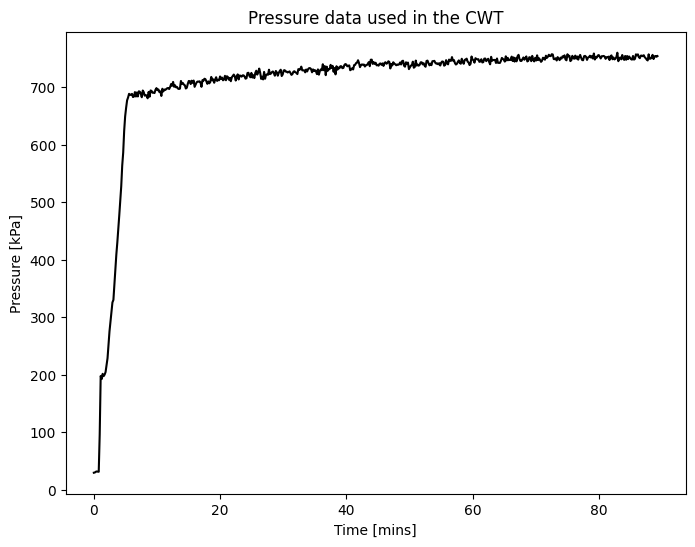

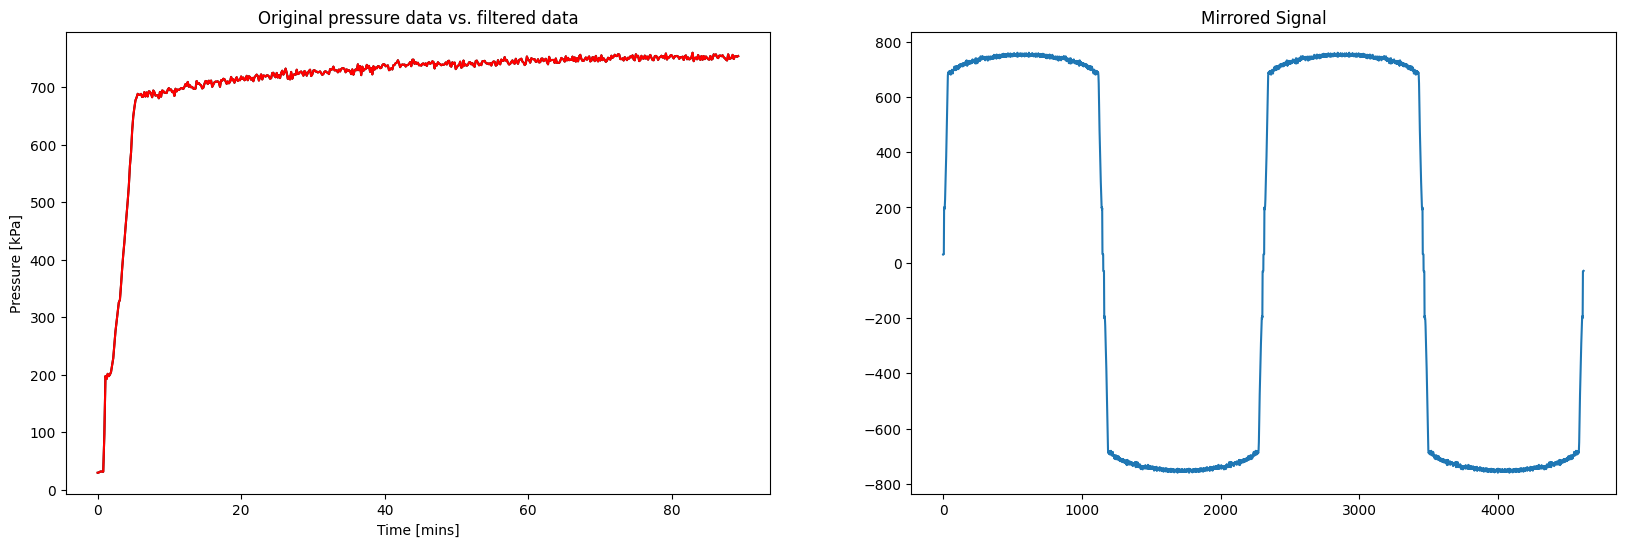

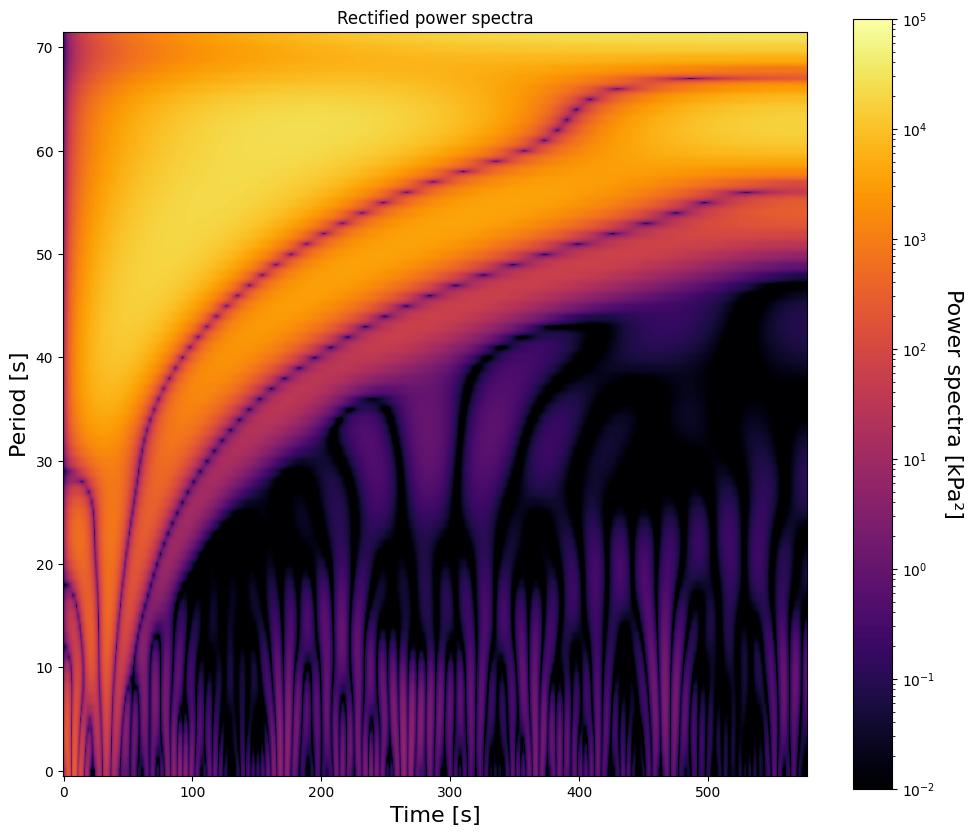

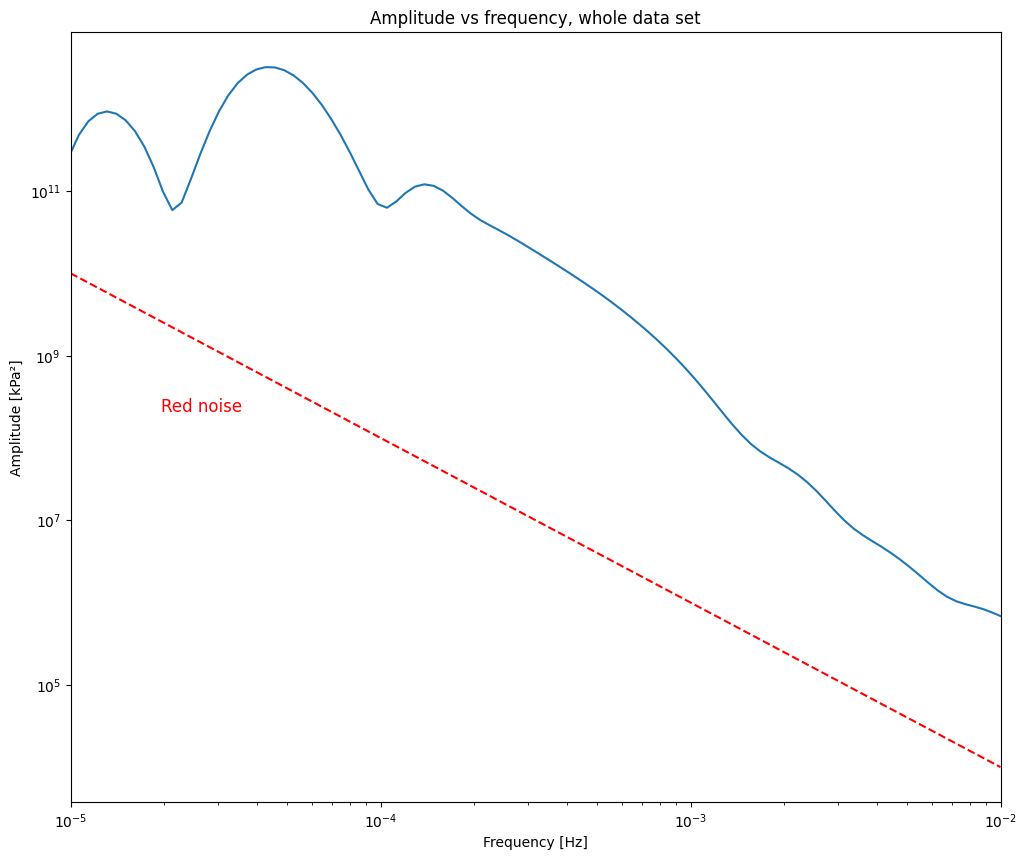

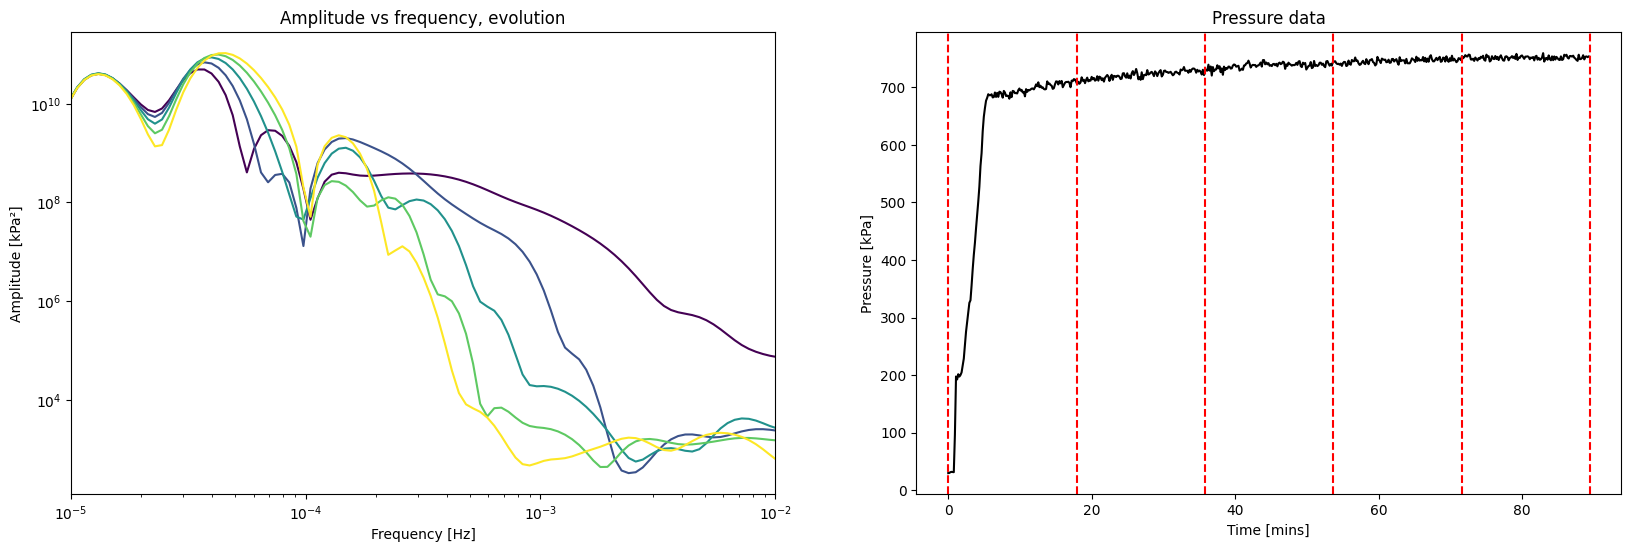

In [143]:
#### Variables for wavelet analysis  ####
dt = 9.3  #interval between pressure readings (in seconds) 
mirror = True
wf = 'dog' # or 'morlet'
om0 = 6
dj=0.1
mirrormethod = 2 # 1 or 2 (mirroring method reduces end effects, so type of mirroring depends on the pressure signal and overall trend)

#filtering can be used to reduce the data set size, filter options are 'None', 1 and 2. Window size for filtering can be modified in the function itself. 
pressure_data, freq, power = plotting_wavelet(infile = 'core_scale_oil.dat', filter = 'None', dt = dt, mirror = mirror, mirrormethod = mirrormethod, wavelet = wf, dj = dj, om0 = om0 )
  